In [1]:
library(shiny)
library(igraph)
library(tidyverse)
library(patchwork)
library(RColorBrewer)
library(Seurat)
library(SeuratWrappers)
library(anndata)
devtools::load_all("/opt/work/home/liz0f/monocle3")
options(shiny.host="0.0.0.0",shiny.port=34000)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() mas

# Process Seurat Object

In [2]:
downstream_dir="/opt/work/datawaha_sfb/liz0f/Long-read-RNA-seq/downstream/Colon_PS017-PS033-bc295-combined_visualization-ClusterFull-AllCellTypes"
expr=readRDS(file.path(downstream_dir,"Seurat","expr.enterocyte_split.rds"))

In [3]:
get_canonical_epi_cells=function(expr){

    tsne_coords=Embeddings(expr[["tsne"]])
    cells.selection=unique(read.csv("cell_selection.txt",header=FALSE)$V1)
    
    expr_epi=expr[,(expr$ClusterMidway=="Epi")&!(colnames(expr)%in%cells.selection )]
    return(expr_epi)
}
expr_epi=get_canonical_epi_cells(expr)

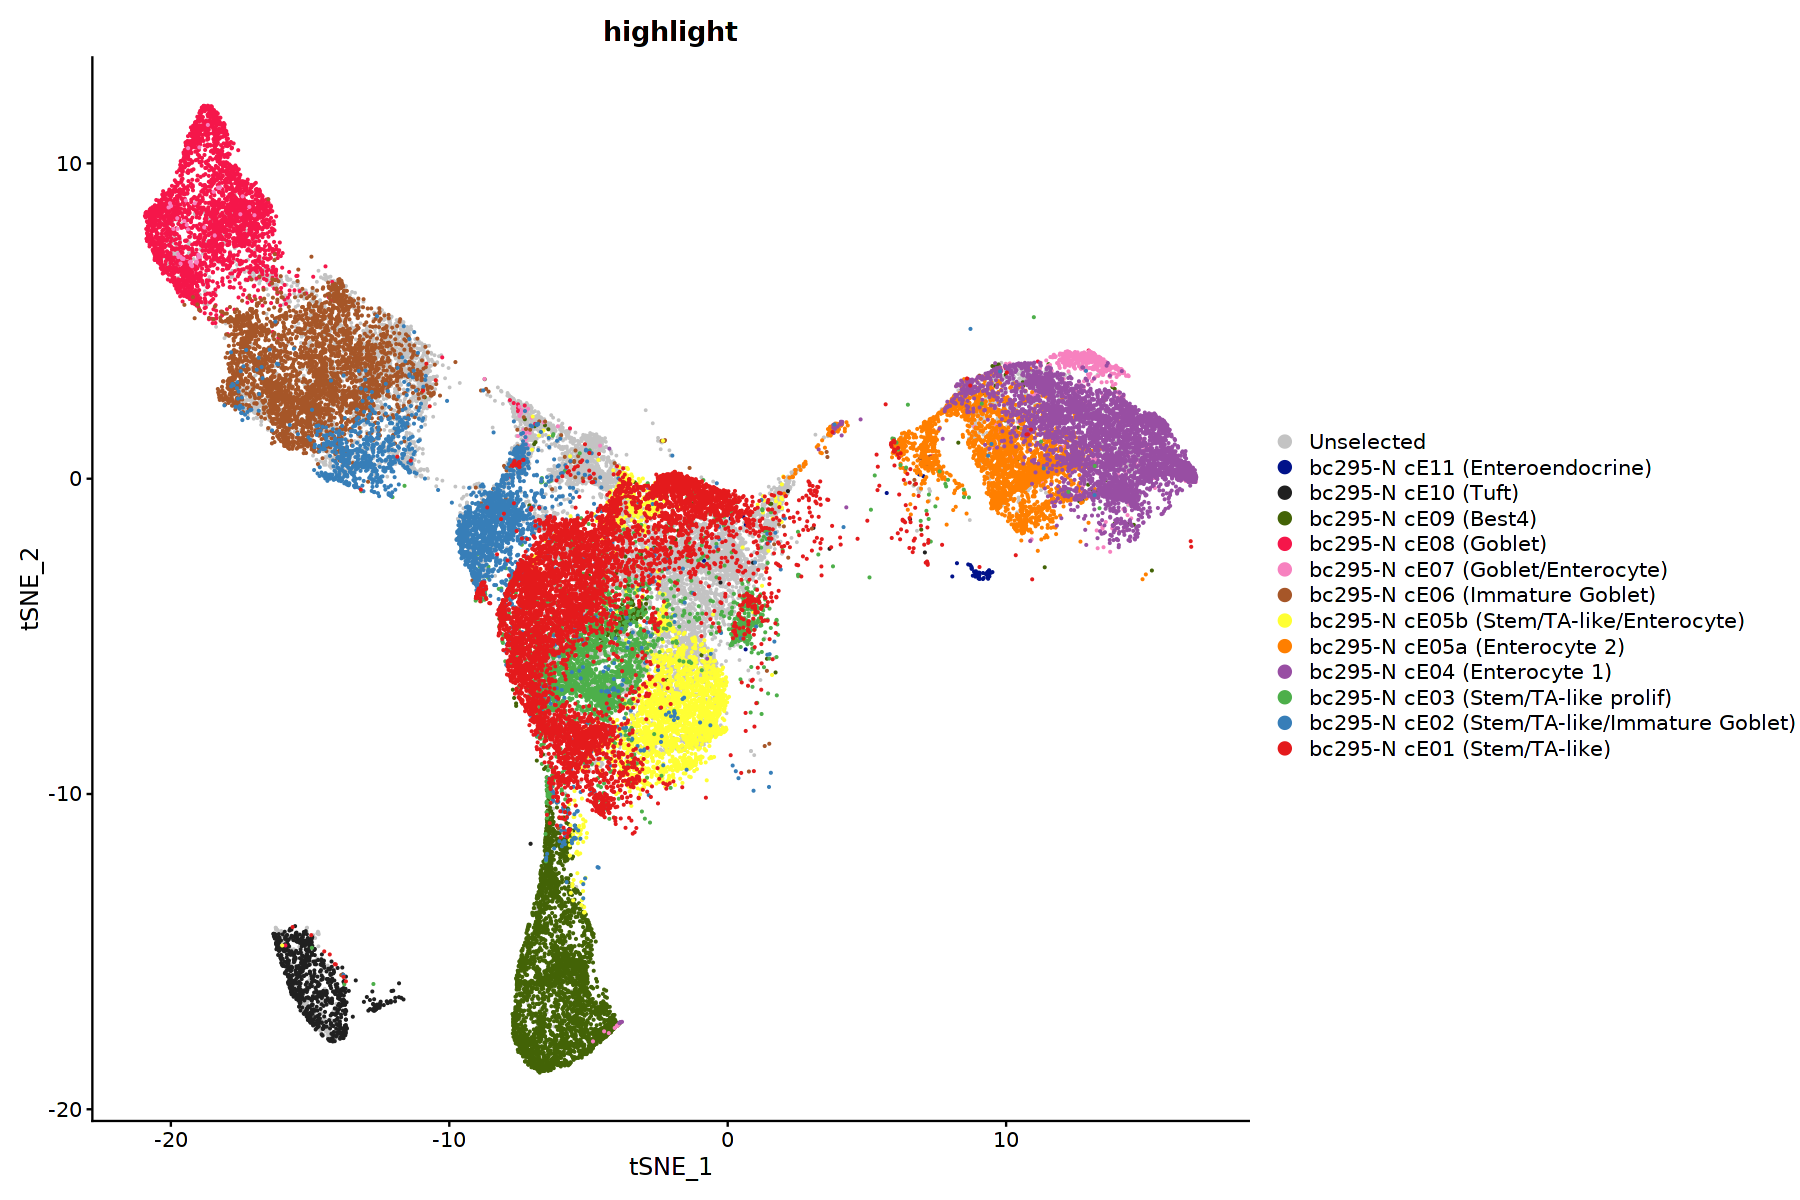

In [12]:
options(repr.plot.width=15, repr.plot.height=10)

palette=rev(c(brewer.pal(8,"Set1"),c("#f5164a","#436306","#202020","#01128A")))

p1=DimPlot(
    expr_epi, 
    reduction = "tsne", 
    group.by="sample_source", 
    cells.highlight=list(
        `bc295-N cE01 (Stem/TA-like)`=expr_epi@meta.data %>% dplyr::filter(sample_source=="bc295" & ClusterFull2=="cE01 (Stem/TA-like)") %>% rownames(),
        `bc295-N cE02 (Stem/TA-like/Immature Goblet)`=expr_epi@meta.data %>% dplyr::filter(sample_source=="bc295" & ClusterFull2=="cE02 (Stem/TA-like/Immature Goblet)") %>% rownames(),
        `bc295-N cE03 (Stem/TA-like prolif)`=expr_epi@meta.data %>% dplyr::filter(sample_source=="bc295" & ClusterFull2=="cE03 (Stem/TA-like prolif)") %>% rownames(),
        `bc295-N cE04 (Enterocyte 1)`=expr_epi@meta.data %>% dplyr::filter(sample_source=="bc295" & ClusterFull2=="cE04 (Enterocyte 1)") %>% rownames(),
        `bc295-N cE05a (Enterocyte 2)`=expr_epi@meta.data %>% dplyr::filter(sample_source=="bc295" & ClusterFull2=="cE05a (Enterocyte 2)") %>% rownames(),
        `bc295-N cE05b (Stem/TA-like/Enterocyte)`=expr_epi@meta.data %>% dplyr::filter(sample_source=="bc295" & ClusterFull2=="cE05b (Stem/TA-like/Enterocyte)") %>% rownames(),
        `bc295-N cE06 (Immature Goblet)`=expr_epi@meta.data %>% dplyr::filter(sample_source=="bc295" & ClusterFull2=="cE06 (Immature Goblet)") %>% rownames(),
        `bc295-N cE07 (Goblet/Enterocyte)`=expr_epi@meta.data %>% dplyr::filter(sample_source=="bc295" & ClusterFull2=="cE07 (Goblet/Enterocyte)") %>% rownames(),
        `bc295-N cE08 (Goblet)`=expr_epi@meta.data %>% dplyr::filter(sample_source=="bc295" & ClusterFull2=="cE08 (Goblet)") %>% rownames(),
        `bc295-N cE09 (Best4)`=expr_epi@meta.data %>% dplyr::filter(sample_source=="bc295" & ClusterFull2=="cE09 (Best4)") %>% rownames(),
        `bc295-N cE10 (Tuft)`=expr_epi@meta.data %>% dplyr::filter(sample_source=="bc295" & ClusterFull2=="cE10 (Tuft)") %>% rownames(),
        `bc295-N cE11 (Enteroendocrine)`=expr_epi@meta.data %>% dplyr::filter(sample_source=="bc295" & ClusterFull2=="cE11 (Enteroendocrine)") %>% rownames()
    ),
    cols.highlight=palette,
    sizes.highlight=0.1
)

print(p1)


# Convert to CDS

In [4]:
cds_epi=as.cell_data_set(expr_epi)
logcounts(cds_epi)=NULL
cds_epi <- cds_epi[,Matrix::colSums(exprs(cds_epi)) != 0]
cds_epi <- estimate_size_factors(cds_epi)
reducedDims(cds_epi)[['tSNE']]=reducedDims(cds_epi)[['TSNE']]
reducedDims(cds_epi)[['UMAP']]=reducedDims(cds_epi)[['TSNE']]
rowData(cds_epi)$gene_short_name=rownames(cds_epi)
cds_epi=detect_genes(cds_epi)
colData(cds_epi)$ClusterFullUnified = sapply(colData(cds_epi)$ClusterFull2,function(x) gsub('In-house-N ','',x))

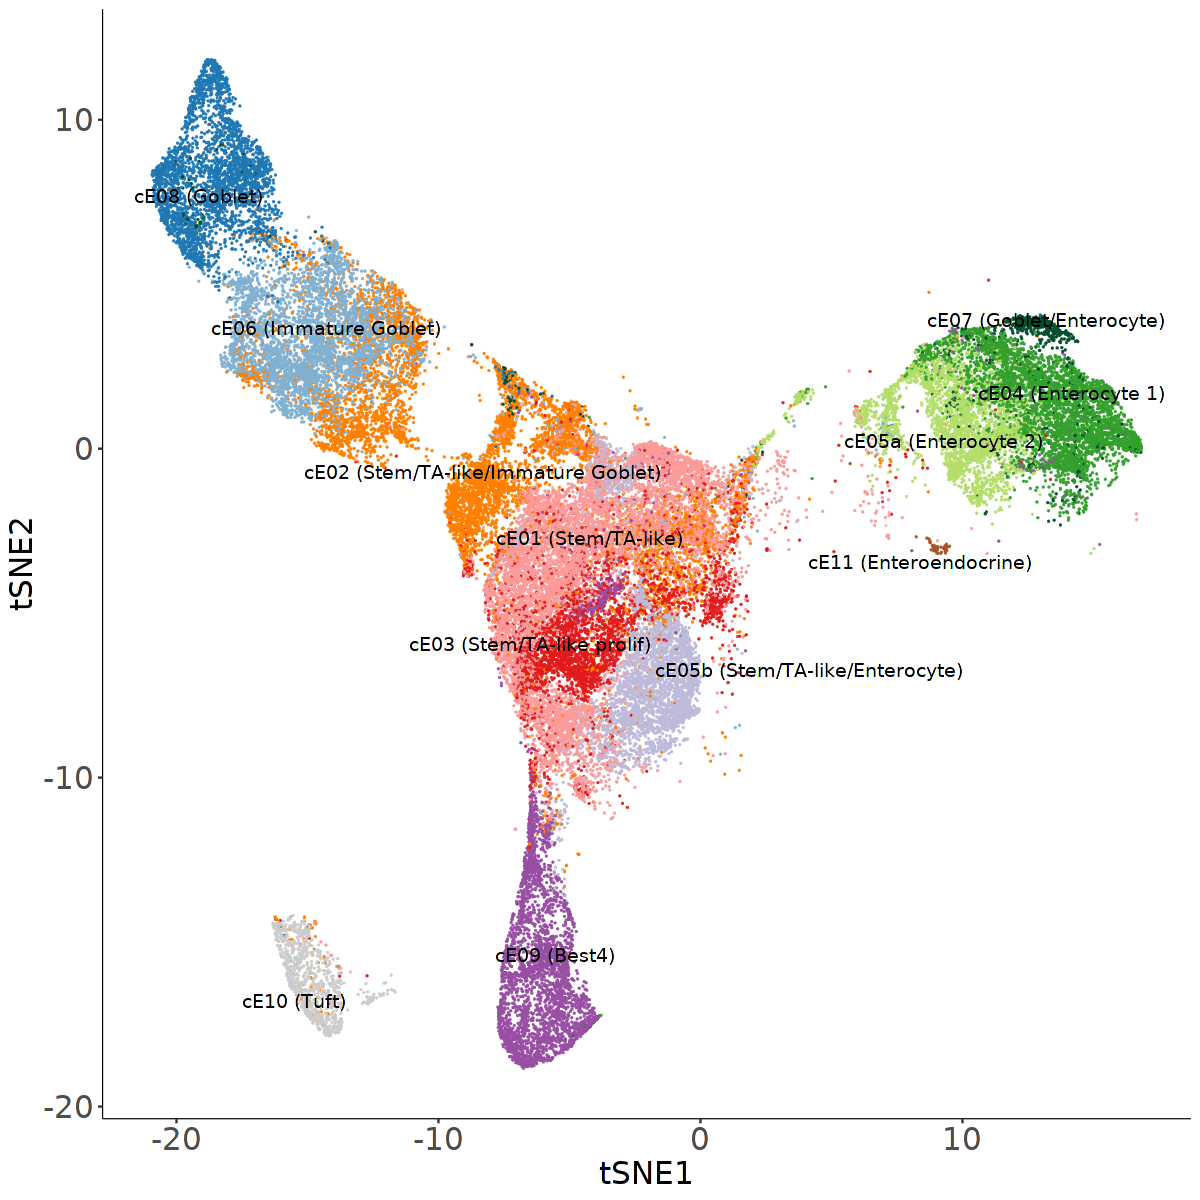

In [6]:
options(repr.plot.width=10, repr.plot.height=10)
celltype_cmap2=c('#F8766D','#DE8C00','#B79F00','#7CAE00','#00BA38','#00C08B','#00BFC4','#00B4F0','#619CFF','#C77CFF','#F564E3','#FF64B0')
all_colors=c(
    "#e31a1c","#fb9a99","#4daf4a","#984ea3","#ff7f00",
    "#ffff33","#a65628","#f781bf","#8dd3c7","#ffffb3",
    "#bebada","#fb8072","#80b1d3","#fdb462","#b3de69",
    "#fccde5","#a6cee3","#1f78b4","#b2df8a","#33a02c",
    "#333333","#808080","cccccc"
)
celltype_cmap=c(
    '#fb9a99','#ff7f00','#e31a1c',
    '#33a02c','#b3de69','#b3de69','#bebada',
    '#80b1d3','#034E2D','#1f78b4',
    '#984ea3','#cccccc','#a65628'
)

# celltype_cmap=celltype_cmap[1:12]
names(celltype_cmap)=c(
    'cE01 (Stem/TA-like)','cE02 (Stem/TA-like/Immature Goblet)','cE03 (Stem/TA-like prolif)',
    'cE04 (Enterocyte 1)','cE05 (Enterocyte 2)','cE05a (Enterocyte 2)','cE05b (Stem/TA-like/Enterocyte)',
    'cE06 (Immature Goblet)','cE07 (Goblet/Enterocyte)','cE08 (Goblet)',
    'cE09 (Best4)','cE10 (Tuft)','cE11 (Enteroendocrine)'
    
)
p=plot_cells(
    cds_epi, 
    label_groups_by_cluster=FALSE,  
    color_cells_by = "ClusterFullUnified",
    group_label_size=4,
    show_trajectory_graph = FALSE,
    trajectory_graph_color = '#999999',
    label_branch_points = FALSE,
    label_leaves = FALSE,
    label_roots = FALSE
) + labs(x="tSNE1",y="tSNE2") +
theme(
    axis.title.x = element_text(size = 18),
    axis.title.y = element_text(size = 18),
    axis.text.x = element_text(size = 18),
    axis.text.y = element_text(size = 18)
) + scale_color_manual(
    values=celltype_cmap
)
print(p)
if(FALSE){
    ggsave("plots/plot_data/lineage_subcluster_plots/lineage.subcluster.tSNE.pdf",p,width=8,height=8)
}


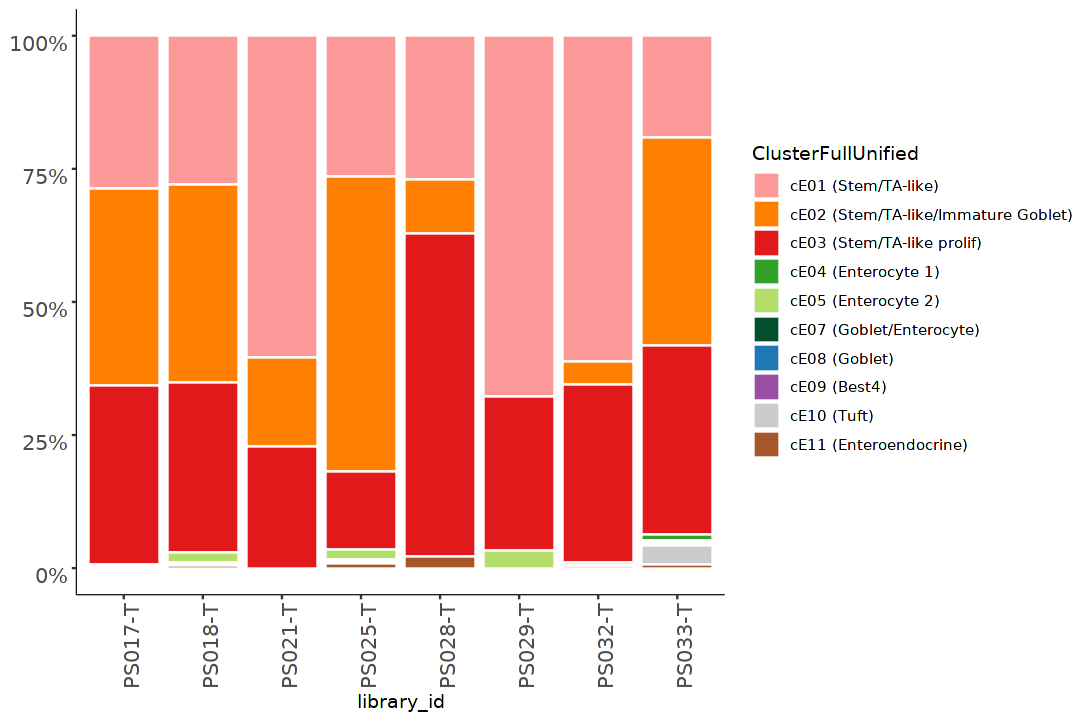

In [7]:
options(repr.plot.width=9, repr.plot.height=6)
map_library_id=function(x){
    x=sapply(strsplit(x,"_"),function(x) {
        x=x[2]
        if(x %in% c("PS017-T1","PS017-T2")){
            x="PS017-T"
        } else if (x %in% c("PS017-N1","PS017-N2")){
            x="PS017-N"
        }
        return(x)
    })
    return(x)
}
map_cluster=function(x){
    x=gsub('In-house-T ','',x)
    return(x)
}
plot_data=expr@meta.data %>% 
    filter(ClusterMidway %in% c("EpiT") & sample_source=='in-house') %>%
    mutate(library_id=map_library_id(library_id),ClusterFullUnified=map_cluster(ClusterFull2)) %>%
    dplyr::count(condition,library_id,ClusterMidway,ClusterFullUnified) %>%
    group_by(library_id) %>%
    mutate(prop = prop.table(n)) %>%
    arrange(condition)

p=ggplot(data=plot_data) + 
    geom_col(mapping=aes(x=library_id,y=prop,fill=ClusterFullUnified),color="white") +
    scale_y_continuous(labels = scales::percent) +
    scale_fill_manual(
        values=celltype_cmap
    ) +
    labs(y=NULL) + 
    monocle_theme_opts() +
    theme(
        axis.text.x = element_text(angle = 90,vjust = 1,  hjust=1, size = 12),
        axis.text.y = element_text(vjust = 1,  hjust=1, size = 12)
    )
print(p)
if(FALSE){
    ggsave("plots/plot_data/lineage_subcluster_plots/EpiT.subcluster.proportion.pdf",p,width=9,height=6)
}


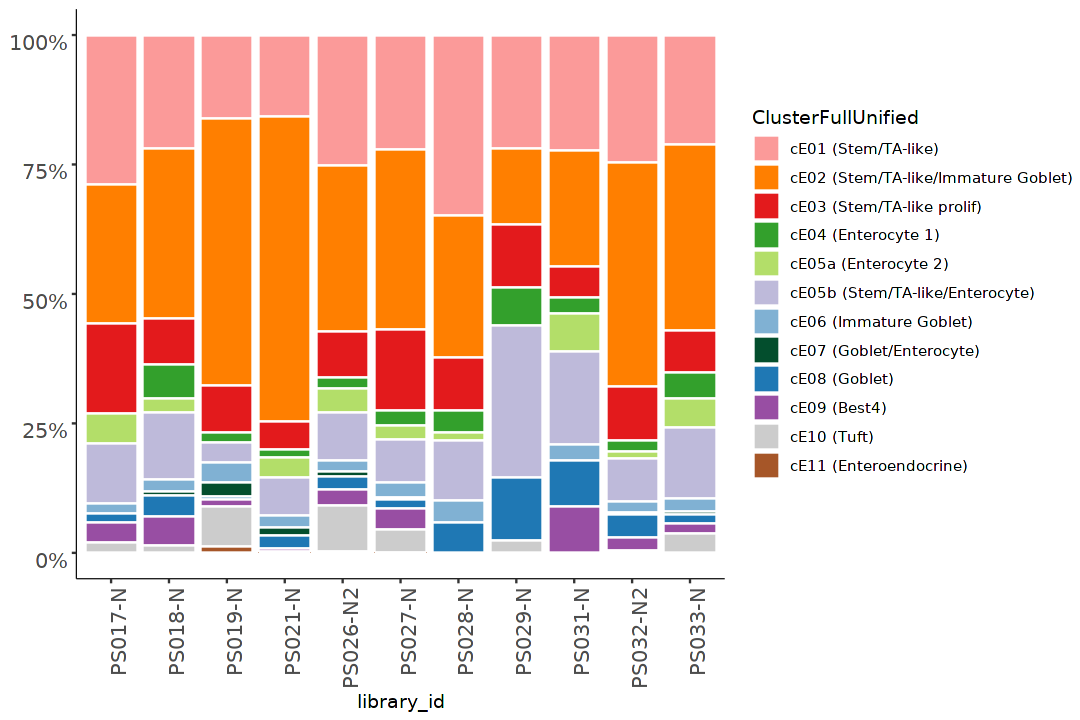

In [430]:
options(repr.plot.width=9, repr.plot.height=6)

plot_data=as.data.frame(colData(cds_epi)) %>%
    filter(ClusterMidway %in% c("Epi") & sample_source=='in-house') %>%
    mutate(library_id=map_library_id(library_id)) %>% 
    dplyr::count(condition,library_id,ClusterMidway,ClusterFullUnified) %>%
    group_by(library_id) %>%
    mutate(prop = prop.table(n)) %>%
    arrange(condition)

p=ggplot(data=plot_data) + 
    geom_col(mapping=aes(x=library_id,y=prop,fill=ClusterFullUnified),color="white") +
    scale_y_continuous(labels = scales::percent) +
    scale_fill_manual(
        values=celltype_cmap
    ) +
    labs(y=NULL) + 
    monocle_theme_opts() +
    theme(
        axis.text.x = element_text(angle = 90,vjust = 1,  hjust=1, size = 12),
        axis.text.y = element_text(vjust = 1,  hjust=1, size = 12)
    )
                  
print(p)
ggsave("plots/plot_data/lineage_subcluster_plots/EpiN.subcluster.proportion.pdf",p,width=9,height=6)

In [14]:
cds_epi <- cluster_cells(cds_epi, k= 60, random_seed=10)


No trajectory to plot. Has learn_graph() been called yet?



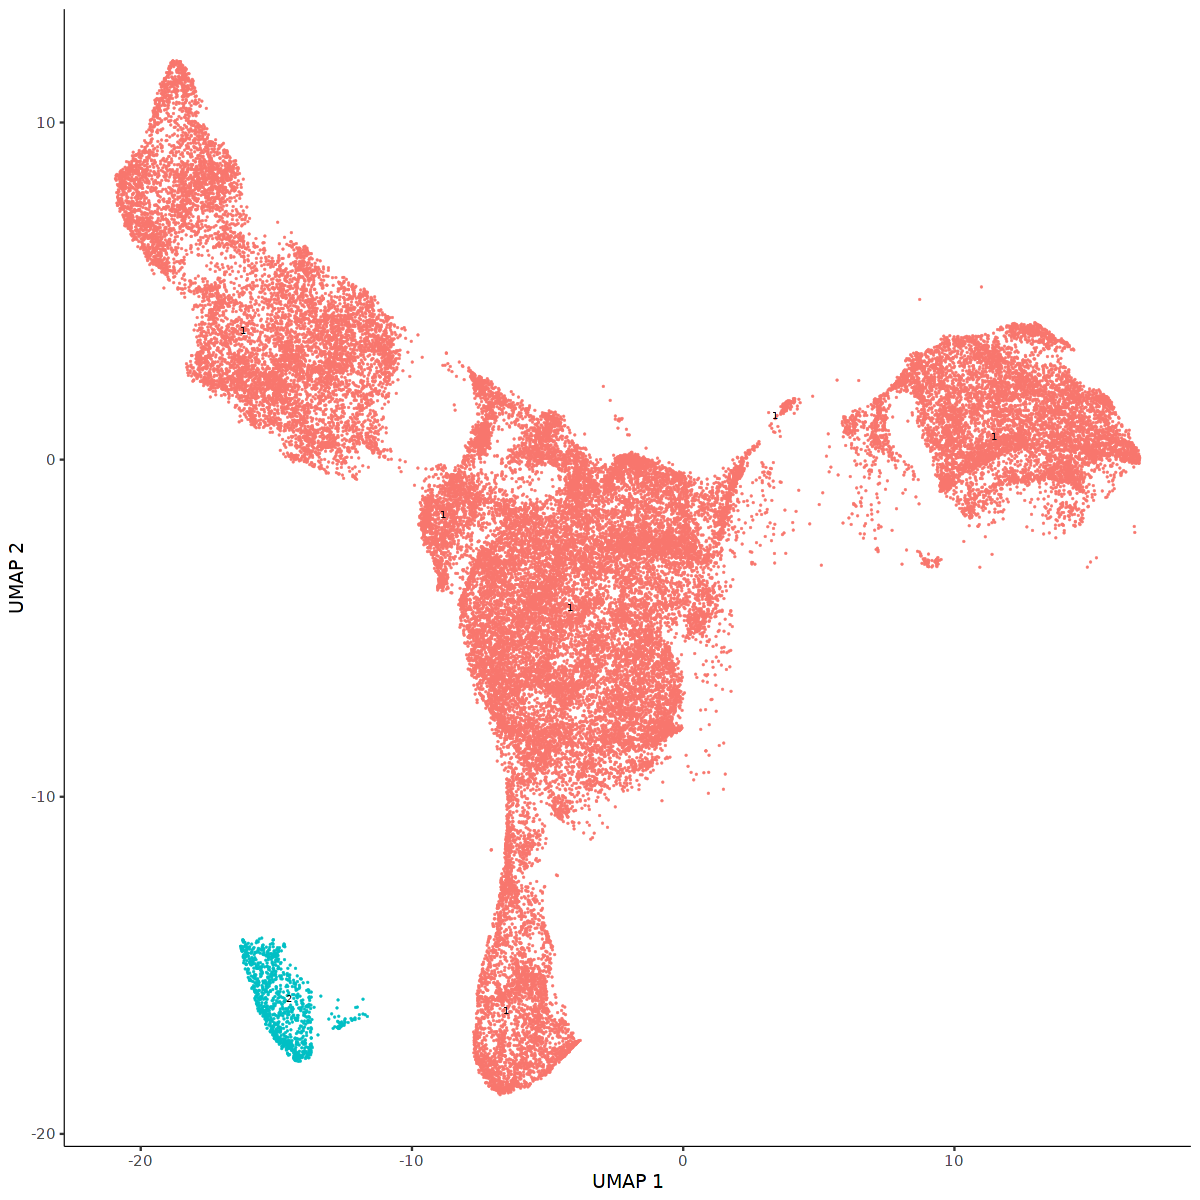

In [15]:
plot_cells(cds_epi, color_cells_by = "partition", reduction_method='UMAP')

In [16]:
cds_epi <- learn_graph(cds_epi)

  |======================================================================| 100%
  |======================================================================| 100%


In [17]:
get_earliest_principal_node <- function(cds, cell_barcodes){
  cell_ids <- cell_barcodes
  
  closest_vertex <-
  cds@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
  closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
  root_pr_nodes <-
  igraph::V(principal_graph(cds)[["UMAP"]])$name[
      as.numeric(
        names(
            which.max(
                table(closest_vertex[cell_ids,])
            )
        )
    )]
  
  root_pr_nodes
}

In [18]:
stem_cell_types=c(
    'cE01 (Stem/TA-like)',
    'cE02 (Stem/TA-like/Immature Goblet)',
    'cE03 (Stem/TA-like prolif)',
    'In-house-N cE01 (Stem/TA-like)',
    'In-house-N cE02 (Stem/TA-like/Immature Goblet)',
    'In-house-N cE03 (Stem/TA-like prolif)'
)
get_stem_cell_populations=function(cds_epi){
    center=c(-2,-2)
    radius=0.3
    tSNE_coords=reducedDim(cds_epi,"tSNE")
    mask=((tSNE_coords[,1]-center[1])**2+(tSNE_coords[,2]-center[2])**2)<radius**2
    colnames(cds_epi)[mask]
}

earliest_pnode=get_earliest_principal_node(
    cds_epi, cell_barcodes=get_stem_cell_populations(cds_epi))
print(earliest_pnode)
cds_epi <- order_cells(cds_epi)

[1] "Y_89"


lizx: The R interpreter is in non-interactive mode

Warning message:
“`select_()` was deprecated in dplyr 0.7.0.
Please use `select()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”

Listening on http://0.0.0.0:34000



In [180]:
options(repr.plot.width=10, repr.plot.height=10)
p=plot_cells(cds_epi,
           color_cells_by = "ClusterUnified",
           label_cell_groups=F,
           label_groups_by_cluster=F,
           label_leaves=F,
           label_branch_points=F,
           label_principal_points=F,
           label_root=F,
           graph_label_size=2.5
) + labs(x="tSNE1",y="tSNE2") + 
theme(
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text.x = element_text(size = 25),
    axis.text.y = element_text(size = 25),
    legend.text = element_text(size = 20),
    legend.title =  element_text(size = 20),
    legend.key.height = unit(1, 'cm'),
    legend.key.width = unit(0.8, 'cm'),
)
print(p)
# ggsave("plots/lineages.pseudotime.tsne.pdf",p,width=10,height=10)

ERROR: Error: color_cells_by must one of 'cluster', 'partition', 'pseudotime, or a column in the colData table.


# Selecting Branches and Moran Test

In [184]:
cds_epi_save_fp="PacBio/downstream/combined/lineage_analysis/cds_epi.rds"
if(FALSE){
    saveRDS(cds_epi,cds_epi_save_fp)
} else{
    cds_epi=readRDS(cds_epi_save_fp)
}

In [163]:
graph_test_and_marker_plot=function(cds,prefix){
    out_dir = sprintf("PacBio/downstream/combined/lineage_analysis/%s",prefix)
    plot_dir = file.path(out_dir,"marker_gene_plots")
    dir.create(
        plot_dir,
        recursive=TRUE,showWarnings = FALSE
    )
    
    moran_fp = file.path(out_dir,"moran_test--gene_level.csv")
    if(file.exists(moran_fp)){
        cds_pr_test_res=read.csv(moran_fp)
    } else {
        cds_pr_test_res = graph_test(cds, neighbor_graph="principal_graph", cores=20)
        cds_pr_test_res = cds_pr_test_res %>% dplyr::arrange(desc(morans_I))
        write.csv(cds_pr_test_res,moran_fp,row.names=FALSE)
    }
    
    top50_genes = cds_pr_test_res %>% 
        dplyr::filter(status=='OK') %>% 
        dplyr::arrange(desc(morans_I)) %>% 
        dplyr::slice(1:100) %>% 
        pull(gene_short_name) 
    
    for(i in 0:9){
        p = plot_cells(cds_epi,
           genes = top50_genes[(9*i+1):(9*i+9)],
           show_trajectory_graph = FALSE,
           label_cell_groups=F,
           label_groups_by_cluster=F,
           label_leaves=F,
           label_branch_points=F,
           label_principal_points=F,
           label_root=F,
           graph_label_size=5,
           norm_method="log",
           min_expr=1
        ) 
        
        ggsave(file.path(plot_dir,sprintf("plot_%d.png",i)),p)
    }
}



In [164]:
options(repr.plot.width=10,repr.plot.height=10)
p = plot_cells(cds_epi,
           genes = c("MUC2","SERPINA1","TBX10","SLC26A3","PRAP1","TMIGD1","OTOP2","BEST4","CA7"),
           show_trajectory_graph = FALSE,
           label_cell_groups=F,
           label_groups_by_cluster=F,
           label_leaves=F,
           label_branch_points=F,
           label_principal_points=F,
           label_root=F,
           graph_label_size=5,
           norm_method="log",
           min_expr=1
) + 
labs(x="tSNE1",y="tSNE2") +
theme(
    strip.text = element_text(size = 15),
    axis.title.x = element_text(size = 15),
    axis.title.y = element_text(size = 15),
    axis.text.x = element_text(size = 15),
    axis.text.y = element_text(size = 15),
    legend.text = element_text(size = 15),
    legend.title =  element_text(size = 15),
    legend.key.height = unit(1, 'cm'),
    legend.key.width = unit(0.8, 'cm'),
)

ggsave(file.path("plots/plot_data/lineage_marker_plots/3branches_markers.pdf"),p,width=10,height=10)

[1] 505.0687


In [3]:
prefix="goblet_branch"
save_dir="PacBio/downstream/combined/lineage_analysis"
dir.create(file.path(save_dir,prefix),recursive = TRUE, showWarnings = FALSE)
if(FALSE){
    cds_epi.goblet_branch <- choose_cells(cds_epi)
    cds_epi.sub.goblet_branch=cds_epi[,colnames(cds_epi.goblet_branch)]
    saveRDS(cds_epi.sub.goblet_branch,file.path(save_dir,prefix,"subcds.rds"))
} else {
    cds_epi.sub.goblet_branch=readRDS(file.path(save_dir,prefix,"subcds.rds"))
}

In [4]:
prefix="best4_branch"
dir.create(file.path(save_dir,prefix),recursive = TRUE, showWarnings = FALSE)
if(FALSE){
    cds_epi.best4_branch <- choose_cells(cds_epi)
    cds_epi.sub.best4_branch=cds_epi[,colnames(cds_epi.best4_branch)]
    saveRDS(cds_epi.sub.best4_branch,file.path(save_dir,prefix,"subcds.rds"))
} else {
    cds_epi.sub.best4_branch=readRDS(file.path(save_dir,prefix,"subcds.rds"))
}

In [5]:
prefix="enterocyte_branch"
dir.create(file.path(save_dir,prefix),recursive = TRUE, showWarnings = FALSE)
if(FALSE){
    cds_epi.enterocyte_branch <- choose_cells(cds_epi)
    cds_epi.sub.enterocyte_branch=cds_epi[,colnames(cds_epi.enterocyte_branch)]
    saveRDS(cds_epi.sub.enterocyte_branch,file.path(save_dir,prefix,"subcds.rds"))
} else {
    cds_epi.sub.enterocyte_branch=readRDS(file.path(save_dir,prefix,"subcds.rds"))
}

In [39]:
graph_test_and_marker_plot(cds_epi.sub.goblet_branch,"goblet_branch")
graph_test_and_marker_plot(cds_epi.sub.best4_branch,"best4_branch")
graph_test_and_marker_plot(cds_epi.sub.enterocyte_branch,"enterocyte_branch")
graph_test_and_marker_plot(cds_epi,"all_branches")

  |=======================================================| 100%, Elapsed 02:58
[1] 1172.331


Saving 6.67 x 6.67 in image



[1] 116.9363


Saving 6.67 x 6.67 in image



[1] 106.0475


Saving 6.67 x 6.67 in image



[1] 213.3021


Saving 6.67 x 6.67 in image



[1] 224.2904


Saving 6.67 x 6.67 in image



[1] 111.1163


Saving 6.67 x 6.67 in image



[1] 112.9859


Saving 6.67 x 6.67 in image



[1] 137.6278


Saving 6.67 x 6.67 in image



[1] 105.3762


Saving 6.67 x 6.67 in image



[1] 64.67523


Saving 6.67 x 6.67 in image



# Gene Level Pseudotime Plot

maximum expression value: 201.4739 
#(>min_expr):  4566 


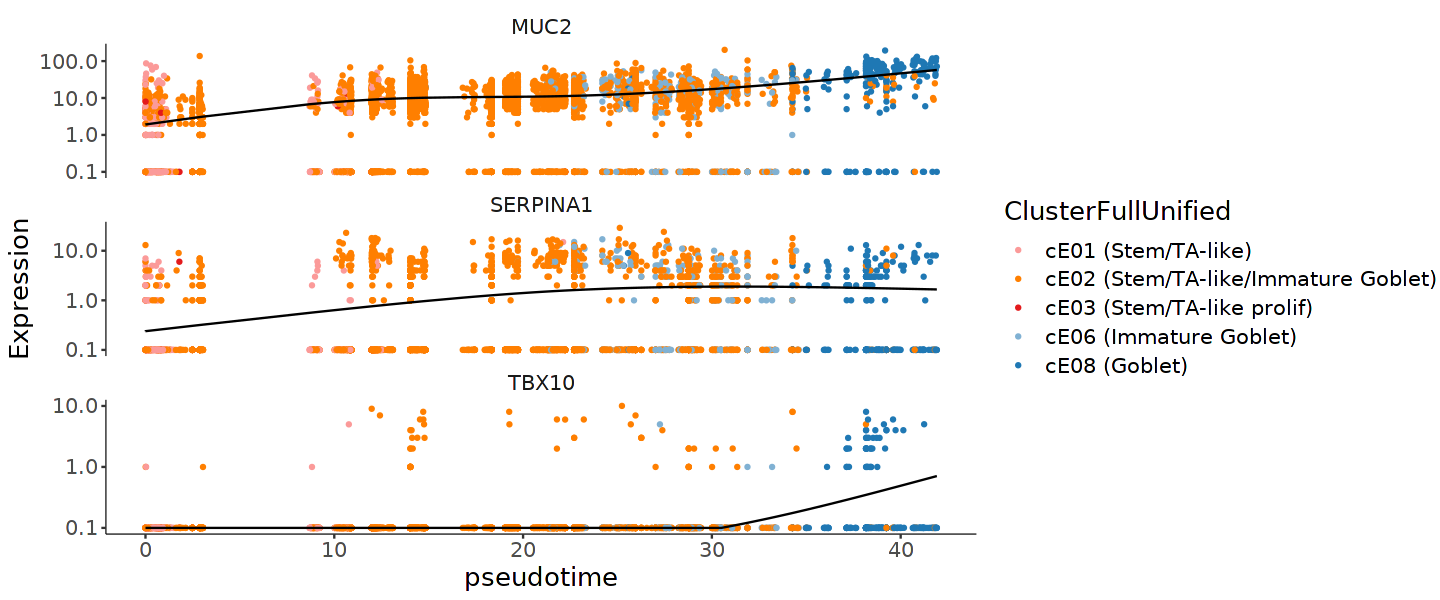

In [389]:
options(repr.plot.width=12,repr.plot.height=5)
genes <- c("MUC2","SERPINA1","TBX10")
lineage_cds = cds_epi.sub.goblet_branch
condition1=colData(lineage_cds)$sample_source=='in-house'
condition2=colData(lineage_cds)$ClusterFullUnified %in% c('cE01 (Stem/TA-like)','cE02 (Stem/TA-like/Immature Goblet)','cE03 (Stem/TA-like prolif)','cE06 (Immature Goblet)','cE08 (Goblet)')
lineage_cds.sub <- lineage_cds[genes,condition1&condition2]
l=plot_genes_in_pseudotime(
    lineage_cds.sub,
     color_cells_by="ClusterFullUnified",
     min_expr=1e-1
)
p=(l[[1]] + scale_color_manual(values=celltype_cmap) + theme(text=element_text(size = 15)))
print(p)
ggsave("plots/plot_data/lineage_marker_plots/goblet_marker_pseudotime.pdf",p,width=12,height=5)

maximum expression value: 72.25462 
#(>min_expr):  1070 


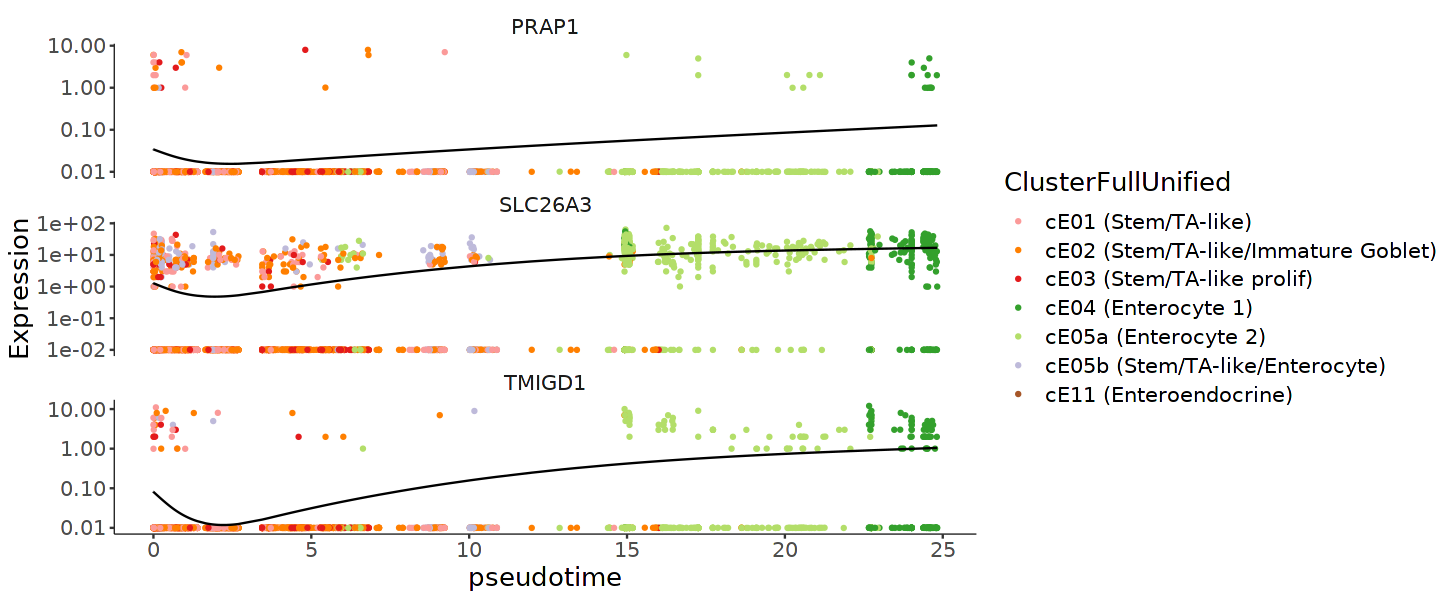

In [390]:
options(repr.plot.width=12,repr.plot.height=5)
genes <- c("SLC26A3","PRAP1","TMIGD1")
lineage_cds = cds_epi.sub.enterocyte_branch
condition1=colData(lineage_cds)$sample_source=='in-house'
condition2=colData(lineage_cds)$ClusterFullUnified %in% c('cE01 (Stem/TA-like)','cE02 (Stem/TA-like/Immature Goblet)','cE03 (Stem/TA-like prolif)','cE04 (Enterocyte 1)','cE05a (Enterocyte 2)','cE05b (Stem/TA-like/Enterocyte)','cE11 (Enteroendocrine)')
lineage_cds.sub <- lineage_cds[genes,condition1&condition2]
l=plot_genes_in_pseudotime(
    lineage_cds.sub,
     color_cells_by="ClusterFullUnified",
     min_expr=1e-2
)
p=(l[[1]] + scale_color_manual(values=celltype_cmap) +  theme(text=element_text(size = 15)))
print(p)
ggsave("plots/plot_data/lineage_marker_plots/enterocyte_marker_pseudotime.pdf",p,width=12,height=5)

maximum expression value: 41.92343 
#(>min_expr):  259 


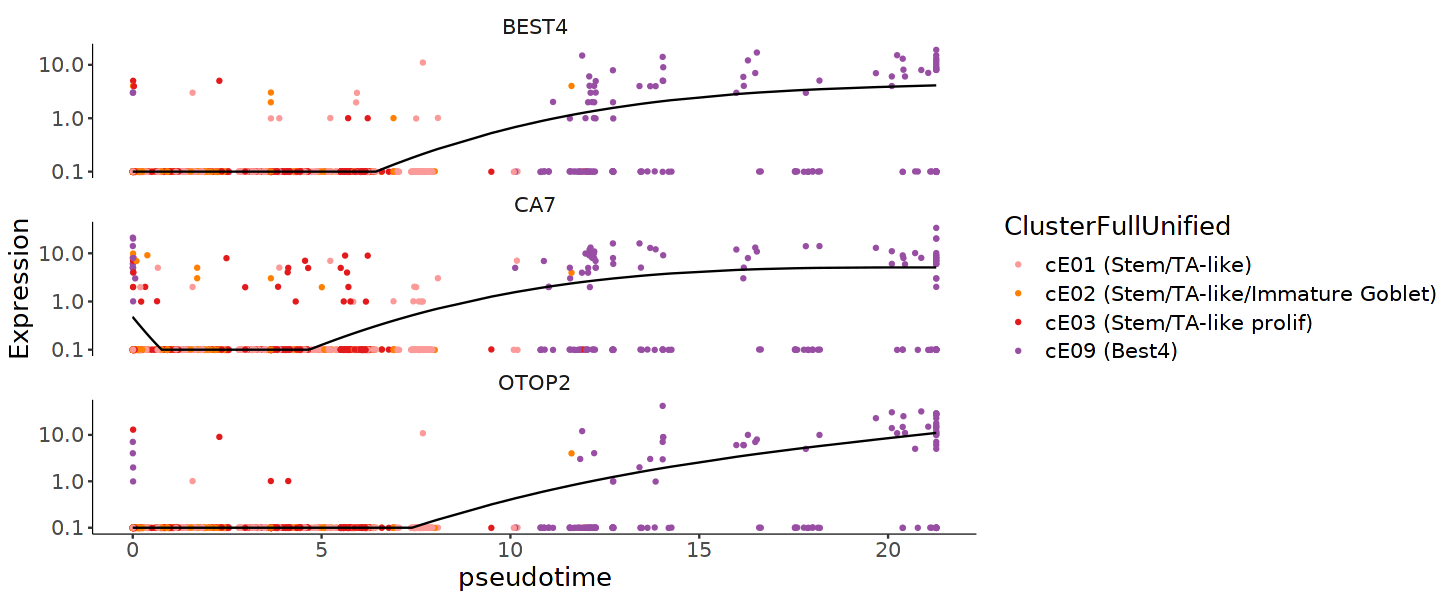

In [391]:
options(repr.plot.width=12,repr.plot.height=5)
genes <- c("OTOP2","BEST4","CA7")
lineage_cds = cds_epi.sub.best4_branch
condition1=colData(lineage_cds)$sample_source=='in-house'
condition2=colData(lineage_cds)$ClusterFullUnified %in% c('cE01 (Stem/TA-like)','cE02 (Stem/TA-like/Immature Goblet)','cE03 (Stem/TA-like prolif)','cE09 (Best4)')
lineage_cds.sub <- lineage_cds[genes,condition1&condition2]
l=plot_genes_in_pseudotime(
    lineage_cds.sub,
     color_cells_by="ClusterFullUnified",
     min_expr=1e-1
)
p=(l[[1]] + scale_color_manual(values=celltype_cmap) + theme(text=element_text(size = 15)))
print(p)
ggsave("plots/plot_data/lineage_marker_plots/best4_marker_pseudotime.pdf",p,width=12,height=5)

# Isoform Level Trajectory Analysis

In [44]:
isoform_counts_ad=read_h5ad("/opt/work/data/liz0f/Long-read-RNA-seq/PacBio/downstream/combined/isoform_counts_ad.anndata")
isoform_data_ad=read_h5ad("/opt/work/data/liz0f/Long-read-RNA-seq/PacBio/downstream/combined/isoform_data_ad.anndata")

In [45]:
isoform_table=read.csv("/opt/work/data/liz0f/Long-read-RNA-seq/PacBio/downstream/combined/simplified_isoform_level-PacBio-gffcmp-clusterfull.unfiltered.csv")

In [66]:
convert_dgRMatrix=function(sm){
    library(spam)
    sm2=as.dgCMatrix.spam(as.spam.dgRMatrix(sm))
    colnames(sm2)=colnames(sm)
    rownames(sm2)=rownames(sm)
    return(sm2)
}
get_isoform_cds=function(cds,isoform_data_ad,isoform_table,estimate_sf=FALSE,filter_isoforms=FALSE){
    common.cells = intersect(colnames(cds),rownames(isoform_data_ad))
    cat("#common.cells:",length(common.cells),"\n")
    flush.console()
    
    isoform_data=convert_dgRMatrix(t(isoform_data_ad[common.cells,]$X))
    expressed.cells=common.cells[colSums(isoform_data)>0]
    
    cat("#expressed.cells:",length(expressed.cells),"\n")
    flush.console()
    
    isoform_data = isoform_data[,expressed.cells]
    isoform_cds=new_cell_data_set(isoform_data)
    
    rowData(isoform_cds)$gene_short_name=rownames(isoform_cds)
    rownames(isoform_table)=isoform_table$Isoform
    rowData(isoform_cds)$gene_symbol=isoform_table[rownames(isoform_cds),"GeneSymbol"]
    colData(isoform_cds)$ClusterFullUnified=colData(cds[,expressed.cells])$ClusterFullUnified
    isoform_cds=detect_genes(isoform_cds)
    if(filter_isoforms){
        isoform_cds=isoform_cds[rowData(isoform_cds)$num_cells_expressed>0,]
    }
    
    principal_graph(isoform_cds)=principal_graph(cds[,expressed.cells])
    principal_graph_aux(isoform_cds)=principal_graph_aux(cds[,expressed.cells])

    reducedDims(isoform_cds)[['UMAP']]=reducedDims(cds)[['UMAP']][colnames(isoform_cds),]
    
    if(estimate_sf){
        isoform_cds=estimate_size_factors(isoform_cds)
    } else{
        colData(isoform_cds)$Size_Factor=1
    }
    
    return(isoform_cds)
}

isoform_cds_epi.counts = get_isoform_cds(
    cds_epi, 
    isoform_counts_ad, 
    isoform_table,
    estimate_sf = TRUE, 
    filter_isoforms= TRUE
)

isoform_cds_epi.sub.goblet_branch.counts = get_isoform_cds(
    cds_epi.sub.goblet_branch, 
    isoform_counts_ad, 
    isoform_table,
    estimate_sf = TRUE, 
    filter_isoforms= TRUE
)

isoform_cds_epi.sub.best4_branch.counts = get_isoform_cds(
    cds_epi.sub.best4_branch, 
    isoform_counts_ad, 
    isoform_table,
    estimate_sf = TRUE, 
    filter_isoforms= TRUE
)

isoform_cds_epi.sub.enterocyte_branch.counts = get_isoform_cds(
    cds_epi.sub.enterocyte_branch, 
    isoform_counts_ad, 
    isoform_table,
    estimate_sf = TRUE, 
    filter_isoforms= TRUE
)



#common.cells: 7946 
#expressed.cells: 7579 


Warning message in new_cell_data_set(isoform_data):
“Warning: gene_metadata must contain a column verbatim named 'gene_short_name' for certain functions.”


#common.cells: 3820 
#expressed.cells: 3609 


Warning message in new_cell_data_set(isoform_data):
“Warning: gene_metadata must contain a column verbatim named 'gene_short_name' for certain functions.”


#common.cells: 1718 
#expressed.cells: 1679 


Warning message in new_cell_data_set(isoform_data):
“Warning: gene_metadata must contain a column verbatim named 'gene_short_name' for certain functions.”


#common.cells: 3228 
#expressed.cells: 3070 


Warning message in new_cell_data_set(isoform_data):
“Warning: gene_metadata must contain a column verbatim named 'gene_short_name' for certain functions.”


In [93]:
isoform_level_graph_test = function(isoform_cds,all_isoform_cds,prefix){
    out_dir = sprintf("PacBio/downstream/combined/lineage_analysis/%s",prefix)
    plot_dir = file.path(out_dir,"isoform_plots")
    dir.create(
        plot_dir,
        recursive=TRUE,showWarnings = FALSE
    )
    
    moran_fp = file.path(out_dir,"moran_test--isoform_level.csv")
    if(file.exists(moran_fp)){
        cds_pr_test_res=read.csv(moran_fp)
    } else {
        cds_pr_test_res = graph_test(isoform_cds, neighbor_graph="principal_graph", cores=20)
        cds_pr_test_res = cds_pr_test_res %>% dplyr::arrange(desc(morans_I))
        write.csv(cds_pr_test_res,moran_fp,row.names=FALSE)
    }
    
    top50_genes = cds_pr_test_res %>% 
        dplyr::filter(status=='OK') %>% 
        dplyr::arrange(desc(morans_I)) %>% 
        dplyr::slice(1:100) %>% 
        pull(gene_short_name) 
    
    for(i in 0:8){
        p = plot_cells(all_isoform_cds,
           genes = top50_genes[(9*i+1):(9*i+9)],
           show_trajectory_graph = FALSE,
           label_cell_groups=F,
           label_groups_by_cluster=F,
           label_leaves=F,
           label_branch_points=F,
           label_principal_points=F,
           label_root=F,
           graph_label_size=5,
           norm_method="size_only",
           min_expr=0.01
        ) 
        ggsave(file.path(plot_dir,sprintf("plot_%d.png",i)),p)
    }
}

isoform_level_graph_test(isoform_cds_epi.counts,isoform_cds_epi.counts,"all_branches")
isoform_level_graph_test(isoform_cds_epi.sub.goblet_branch.counts,isoform_cds_epi.counts,"goblet_branch")
isoform_level_graph_test(isoform_cds_epi.sub.best4_branch.counts,isoform_cds_epi.counts,"best4_branch")
isoform_level_graph_test(isoform_cds_epi.sub.enterocyte_branch.counts,isoform_cds_epi.counts,"enterocyte_branch")

[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 4.254935


Saving 6.67 x 6.67 in image



[1] 8.112028


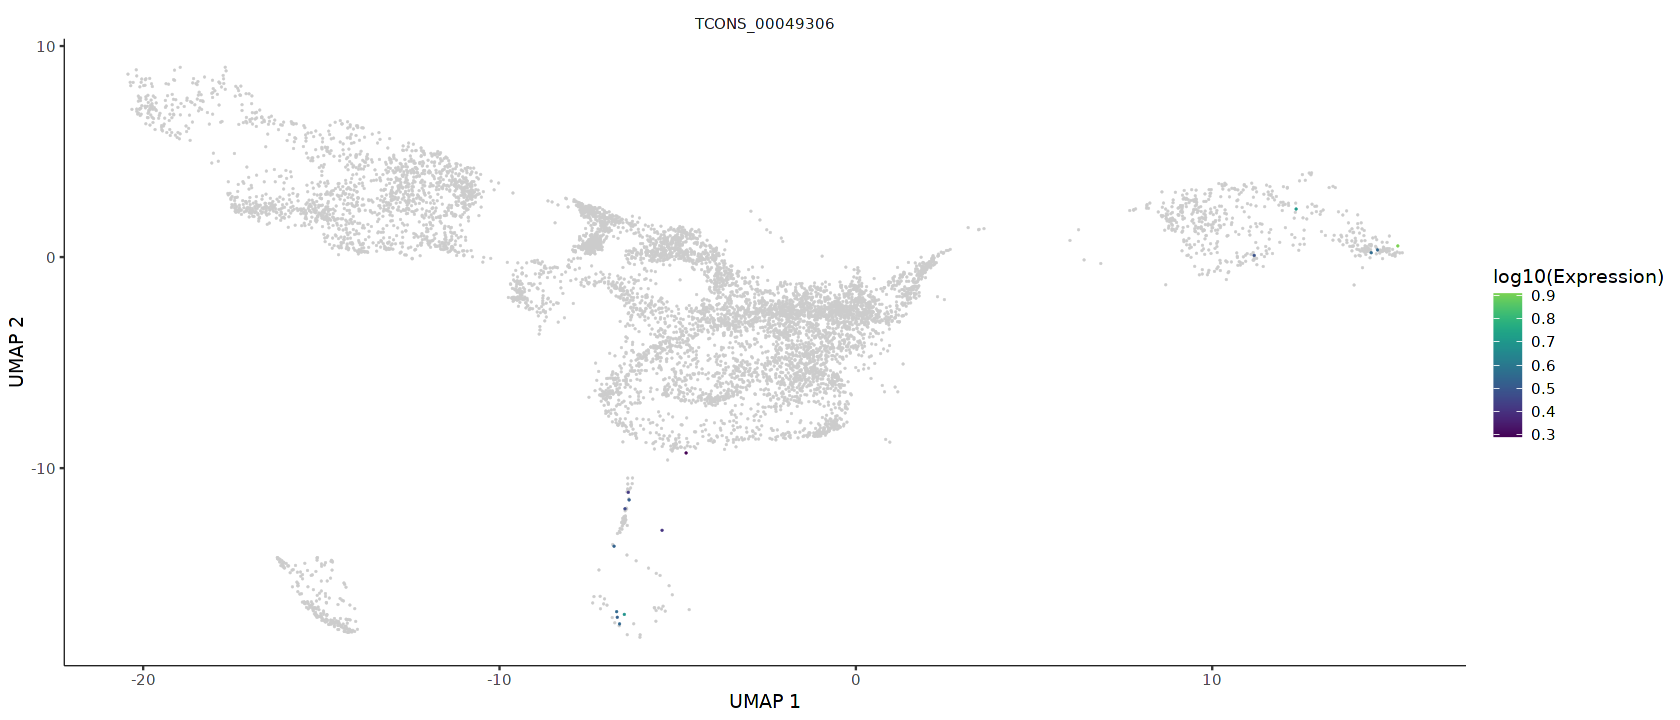

In [231]:
options(repr.plot.width=14,repr.plot.height=6)
p = plot_cells(isoform_cds_epi,
           genes = c("TCONS_00049306"),
           show_trajectory_graph = FALSE,
           label_cell_groups=F,
           label_groups_by_cluster=F,
           label_leaves=F,
           label_branch_points=F,
           label_principal_points=F,
           label_root=F,
           graph_label_size=5,
           norm_method="log",
           min_expr=1e-10
) 
print(p)

ℹ Loading monocle3



maximum expression value: 0.3600803 
#(>min_expr):  5 


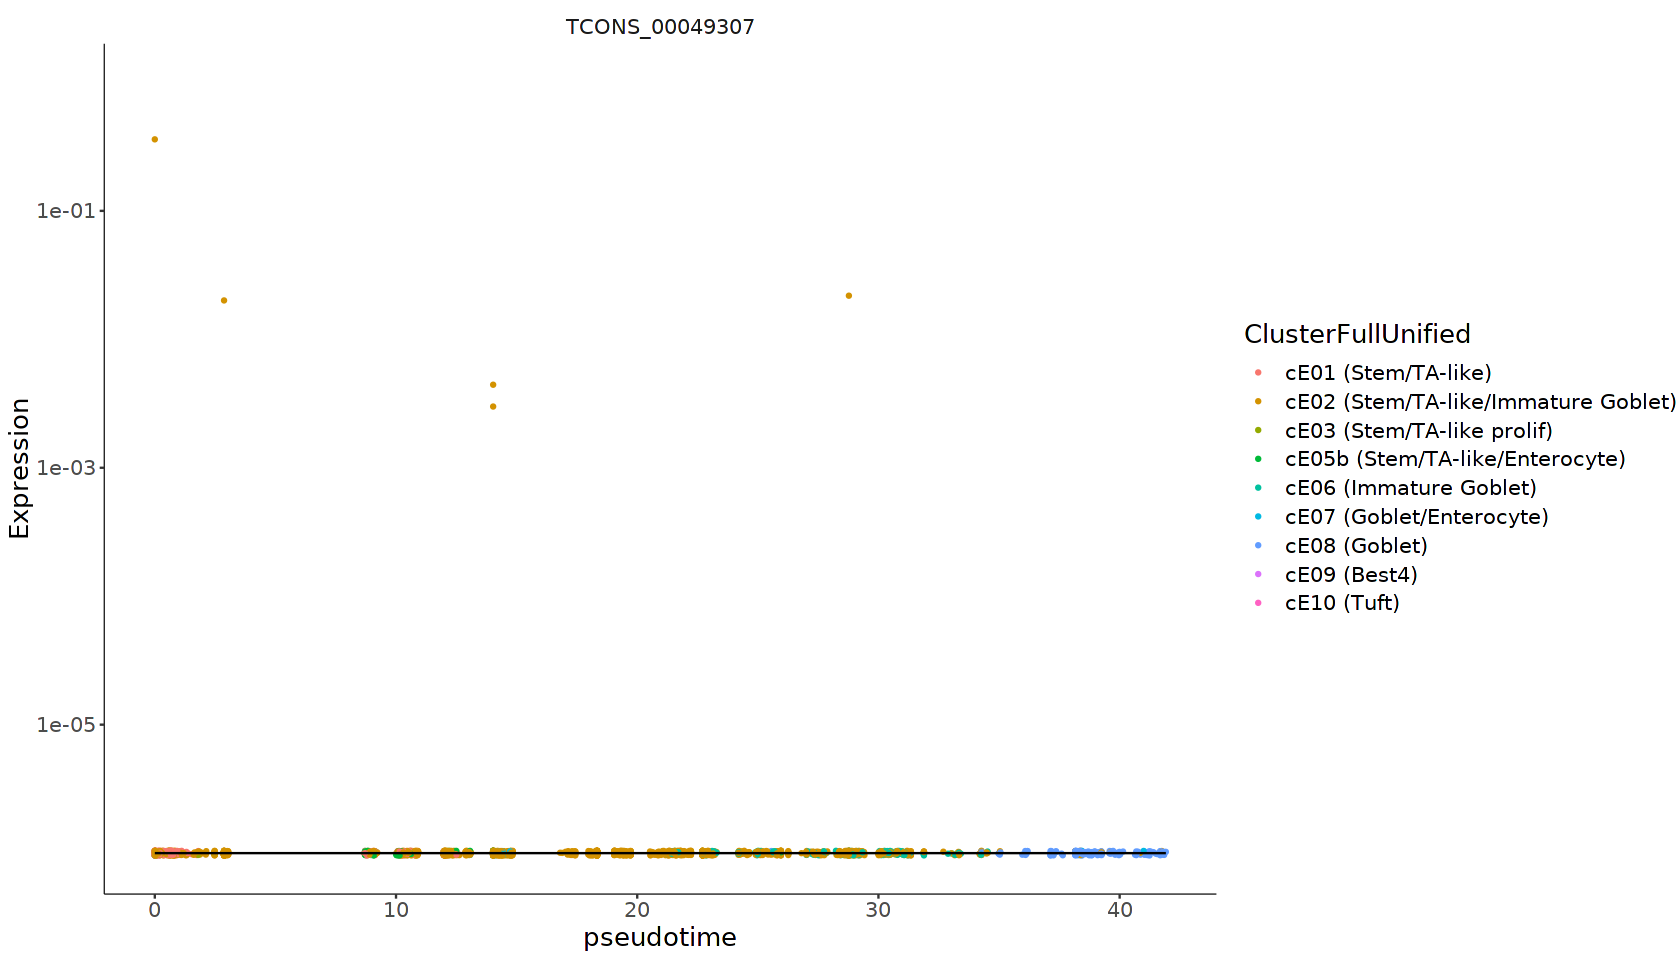

In [244]:
options(repr.plot.width=14,repr.plot.height=8)
devtools::load_all("/opt/work/home/liz0f/monocle3")
isoforms=c("TCONS_00049307")
l=plot_genes_in_pseudotime(
    isoform_cds_epi.sub.goblet_branch.counts[isoforms,],
     color_cells_by="ClusterFullUnified",
     min_expr=1e-6,
    round_interval = 0.00001
)
print(l[[1]] + theme(text=element_text(size = 15)))

ℹ Loading monocle3



maximum expression value: 1.487314 
#(>min_expr):  64 


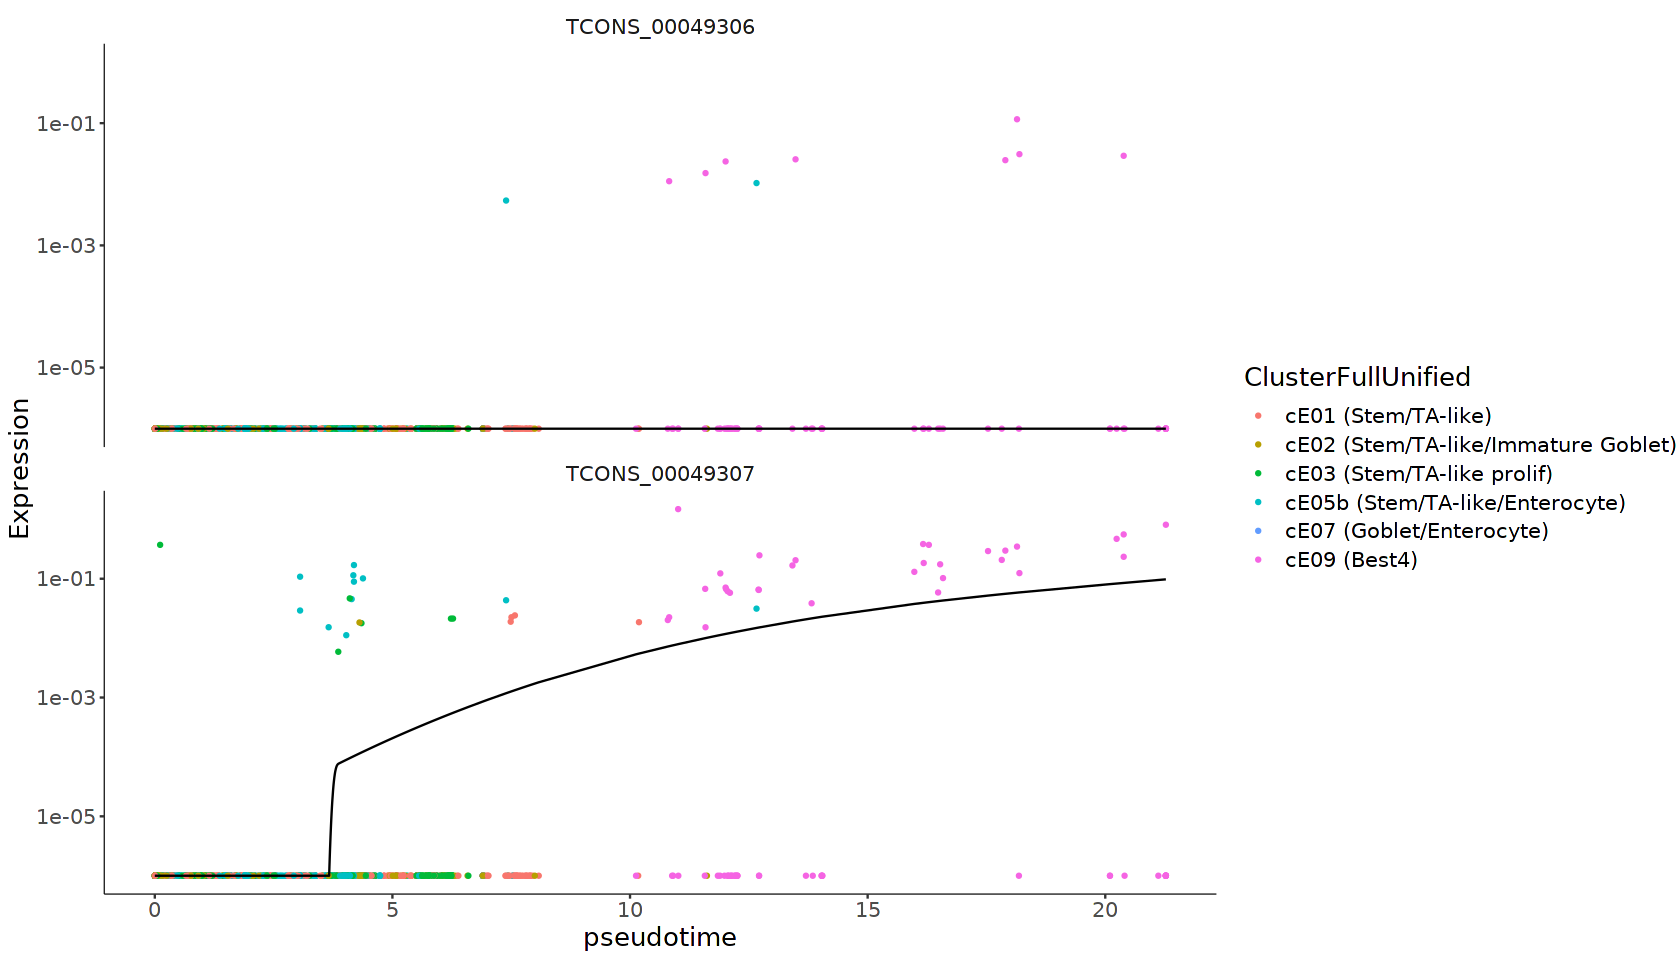

In [242]:
options(repr.plot.width=14,repr.plot.height=8)
devtools::load_all("/opt/work/home/liz0f/monocle3")
isoforms=c("TCONS_00049306","TCONS_00049307")
l=plot_genes_in_pseudotime(
    isoform_cds_epi.sub.best4_branch.counts[isoforms,],
     color_cells_by="ClusterFullUnified",
     min_expr=1e-6,
    round_interval = 0.00001
)
print(l[[1]] + theme(text=element_text(size = 15)))

ℹ Loading monocle3



maximum expression value: 1.487314 
#(>min_expr):  64 


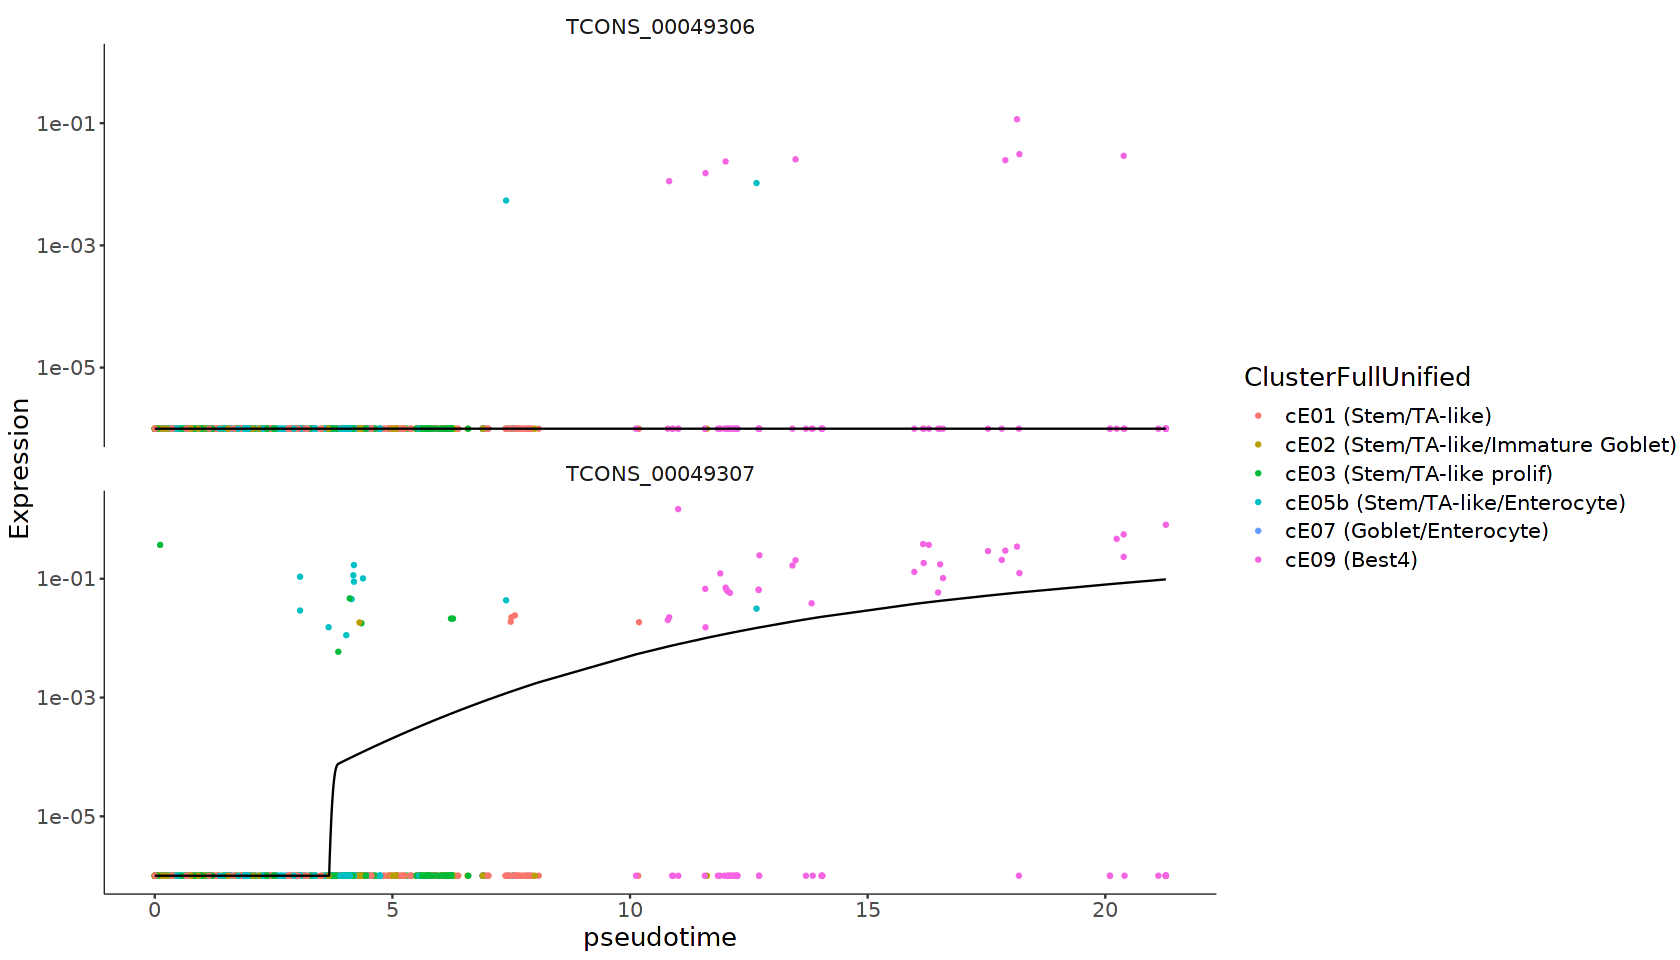

In [119]:
options(repr.plot.width=14,repr.plot.height=8)
devtools::load_all("/opt/work/home/liz0f/monocle3")
isoforms=c("TCONS_00049306","TCONS_00049307")
l=plot_genes_in_pseudotime(
    isoform_cds_epi.sub.best4_branch.counts[isoforms,],
     color_cells_by="ClusterFullUnified",
     min_expr=1e-6,
    round_interval = 0.00001
)
print(l[[1]] + theme(text=element_text(size = 15)))

# gene pseudotime heatmap

## Save Seurat RDS

In [40]:
save_cds_as_seurat=function(cds,prefix,filename,min_expr=0.1){
    out_dir = sprintf("PacBio/downstream/combined/lineage_analysis/%s",prefix)
    expr=as.Seurat(cds)
    expr_data=Matrix::t(Matrix::t(counts(cds))/size_factors(cds))
    expr_data@x=log10(expr_data@x+min_expr)
    expr[["RNA"]]@data=expr_data
    expr=AddMetaData(expr,pseudotime(cds),"pseudotime")
    saveRDS(expr,file.path(out_dir,filename))
}

In [41]:
save_cds_as_seurat(cds_epi,"all_branches","expr.gene_level.Seurat.rds")
save_cds_as_seurat(cds_epi.sub.goblet_branch,"goblet_branch","expr.gene_level.Seurat.rds")
save_cds_as_seurat(cds_epi.sub.best4_branch,"best4_branch","expr.gene_level.Seurat.rds")
save_cds_as_seurat(cds_epi.sub.enterocyte_branch,"enterocyte_branch","expr.gene_level.Seurat.rds")

Warning message in Cells(x = value) == Cells(x = x):
“longer object length is not a multiple of shorter object length”
Warning message in Cells(x = value) == Cells(x = x):
“longer object length is not a multiple of shorter object length”
Warning message in Cells(x = value) == Cells(x = x):
“longer object length is not a multiple of shorter object length”


In [50]:
save_cds_as_seurat(isoform_cds_epi,"all_branches","expr.isoform_level.Seurat.rds")
save_cds_as_seurat(isoform_cds_epi.sub.goblet_branch.counts,"goblet_branch","expr.isoform_level.Seurat.rds")
save_cds_as_seurat(isoform_cds_epi.sub.best4_branch.counts,"best4_branch","expr.isoform_level.Seurat.rds")
save_cds_as_seurat(isoform_cds_epi.sub.enterocyte_branch.counts,"enterocyte_branch","expr.isoform_level.Seurat.rds")

In [ ]:
isoform_level_graph_test(isoform_cds_epi,"all_branches")
isoform_level_graph_test(isoform_cds_epi.sub.goblet_branch,"goblet_branch")
isoform_level_graph_test(isoform_cds_epi.sub.best4_branch,"best4_branch")
isoform_level_graph_test(isoform_cds_epi.sub.enterocyte_branch,"enterocyte_branch")

In [255]:
lineages=list(
    goblet=c('cE01 (Stem/TA-like)','cE02 (Stem/TA-like/Immature Goblet)','cE06 (Immature Goblet)','cE08 (Goblet)')
)
genes_by_pseudotime=function(cds,genes_list,bins=100){
    counts_mat = counts(cds)
    sz = size_factors(cds)
    data_mat = log10(counts_mat / sz + 0.1)
    df = data.frame(
        pseudotime = pseudotime(cds)
    )
    for(gene in genes_list){
        df[[gene]]=data_mat[gene,]
    }
    
    df = df %>% dplyr::arrange(pseudotime) %>% dplyr::filter(is.finite(pseudotime))
    t_min = min(df$pseudotime)
    t_max = max(df$pseudotime)
    df = aggregate(
        df,
        by = list(cut(df$pseudotime, seq(t_min,t_max,len=bins+1))),
        mean
    )
    return(
        list(
            pseudotime=df$pseudotime,
            gene_matrix=t(as.matrix(df[,3:ncol(df),drop=FALSE]))
        )
    )
}
plot_data=genes_by_pseudotime(
    cds_epi[,cds_epi$ClusterFull2 %in% lineages$goblet],
    c("SPINK4","STMN1","CA4")
)